### Reuters Dense TF V1


Code in this file process the Reuters data (single-label multi-class classification). The setup is:

1. The data comes from 10,000 articles shared by Reuters.
2. Each article contains [0...1000] words
3. The Kaggle folks pre-processed the articles so that each article is a 1D array that contains numbers in the
    range(0...10000) corresponding to the words most frequently found in the articles. 
4. The labels is also a 1D array that contains numbers corresponding to the 46 categories of the articles.
5. The pre-processing here is similar to the pre-processing done to the imdb data
6. The model here illustrate the case in which the final layer is made up of more than one class;
   in this case the number of classes (topics) is 46.
7. As it was the case of the imdb setup, the model here also overfits.

    after 20 epochs
                TEST                        VALIDATION
        loss: 0.1097 - acc: 0.9582 - val_loss: 1.0746 - val_acc: 0.8010
'''

In [1]:
# get APIs
from logging import logProcesses
import os, shutil
from platform import python_branch
from syslog import LOG_SYSLOG

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Dropout
from keras.datasets import mnist
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator

2025-02-07 19:11:27.006208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738973487.020680   67828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738973487.024506   67828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 19:11:27.038405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Print APIs version numbers
print ("TF Version   ", tf.__version__)
print ("TF Path      ", tf.__path__[0])
print("Keras version ", keras.__version__)
print("numpy version ", np.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TF Version    2.18.0
TF Path       /drv3/hm3/code/python/tf2.18/tf2.18/lib/python3.12/site-packages/keras/api/_v2
Keras version  3.7.0
numpy version  1.26.4
Num GPUs Available:  1


In [3]:
# enumerate is the reason why this function is so short, enumerate is a very "pythonic" function
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate (sequences):
        results[i, sequence] = 1.
    return results


def vectorize_labels(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate (labels):
        results[i, label] = 1.
    return results


In [7]:
def print_review( item ) :
  for i in item :
    print (i)
  return


def decode_to_text() :
    word_index = reuters.get_word_index()
    reverse_word_index = dict([ (val, key) for (key, val) in word.index.items])
    decoded_text = ' '.join( [reverse_word_index.get (i-3, '?') for i in train_data[0]])
    print ( decoded_text)
    return



In [6]:
# get the data
reuters = tf.keras.datasets.reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data( num_words=10000)

x_train = vectorize_sequences (train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')

v_train_labels = vectorize_labels( train_labels)
v_test_labels = vectorize_labels( test_labels)


In [8]:
# define the model and print params number
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(46, activation='softmax'))

model.summary()


/drv3/hm3/code/python/tf2.18/tf2.18/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738973576.839311   67828 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:08:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# partition the data into train and validation sets
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = v_train_labels[:1000]
partial_y_train = v_train_labels[1000:]

In [10]:
# Compile, train

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)


Epoch 1/20


I0000 00:00:1738973608.634254   67956 service.cc:148] XLA service 0x7445c8003cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738973608.634279   67956 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-07 19:13:28.706671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738973608.751648   67956 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-02-07 19:13:29.545533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 304 bytes spill stores, 304 bytes spill loads

2025-02-07 19:13:29.722424: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_199', 292 byte

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3201 - loss: 3.5178

I0000 00:00:1738973610.790203   67956 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.4038 - loss: 3.2055

2025-02-07 19:13:32.060728: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_199', 340 bytes spill stores, 340 bytes spill loads

2025-02-07 19:13:32.645404: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 200 bytes spill stores, 344 bytes spill loads

2025-02-07 19:13:32.799801: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 368 bytes spill stores, 500 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - acc: 0.4252 - loss: 3.1009 - val_acc: 0.6230 - val_loss: 1.7624
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.6657 - loss: 1.6004 - val_acc: 0.6750 - val_loss: 1.3693
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7374 - loss: 1.1887 - val_acc: 0.7350 - val_loss: 1.1827
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7960 - loss: 0.9476 - val_acc: 0.7770 - val_loss: 1.0657
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8346 - loss: 0.7828 - val_acc: 0.7890 - val_loss: 0.9938
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8611 - loss: 0.6545 - val_acc: 0.7670 - val_loss: 0.9904
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8889 - loss: 0.5371 - val_acc: 0.8140 - val_loss: 0.8981
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9050 - loss: 0.4578 - val_acc: 0.8010 - val_loss: 0.8900
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9216 - loss: 0

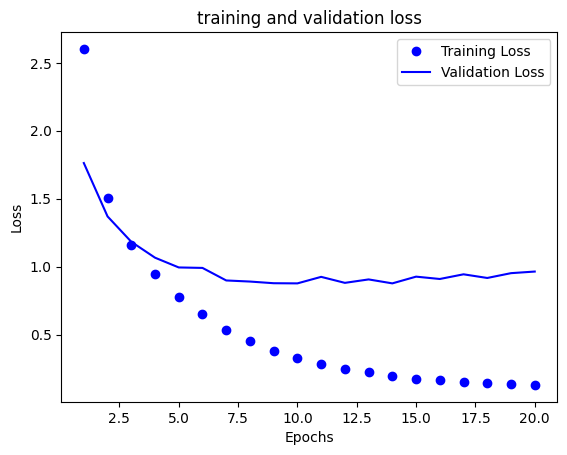

In [11]:
# Plot training and validation loss
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


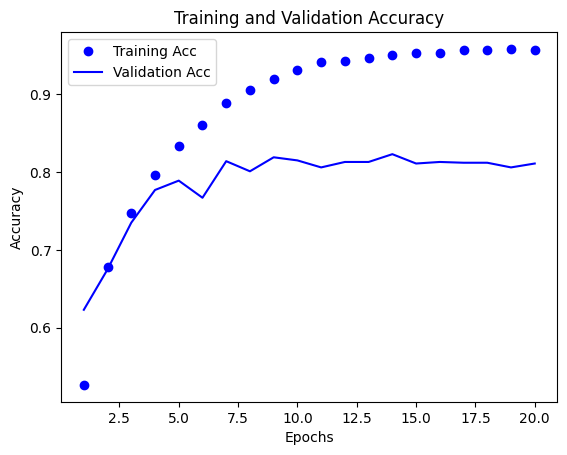

In [12]:
# plot training and validation accuracy
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc,'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [18]:
# Produce cool charts for evaluation
reuters_model=keras.Sequential([layers.Dense(64,activation="relu"),
                                layers.Dense(4,activation="relu"),
                                layers.Dense(46,activation="softmax")])
reuters_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
history = reuters_model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                             validation_data=(x_val, y_val))


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.0616 - loss: 3.7573 - val_accuracy: 0.2040 - val_loss: 3.5268
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1961 - loss: 3.4542 - val_accuracy: 0.2390 - val_loss: 3.2765
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2461 - loss: 3.1810 - val_accuracy: 0.2550 - val_loss: 3.0410
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2562 - loss: 2.9325 - val_accuracy: 0.2490 - val_loss: 2.8115
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2515 - loss: 2.6833 - val_accuracy: 0.2470 - val_loss: 2.5961
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2478 - loss: 2.4530 - val_accuracy: 0.2480 - val_loss: 2.3691
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2551 - loss: 2.2065 - val_accuracy: 0.3750 - val_loss: 2.1628
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4879 - loss: 1.9935 - val_accuracy: 0.5480 - 

In [21]:
predictions = reuters_model.predict(x_test)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
